In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import resampy

In [ ]:
# Define paths and parameters
DATASET_PATH = "/content/drive/MyDrive/flac"
LABEL_FILE_PATH = "/content/ASVspoof2019.LA.cm.train.trn.txt"

In [ ]:
# Function to extract MFCC features from audio files
def extract_features(file_name, n_mfcc=13):
    audio, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_scaled = np.mean(mfccs.T, axis=0)  # Average over time steps
    return mfccs_scaled

# Prepare dataset by extracting MFCC features and labeling data
def prepare_dataset(directory,true_labels):
    features = []
    labels = []

    for file_name,label in tqdm(true_labels.items()):

        file_path = os.path.join(DATASET_PATH, file_name + ".flac")
        # Extract MFCC features
        mfccs = extract_features(file_path)

        features.append(mfccs)
        labels.append(label)

    # Convert to DataFrame
    features_df = pd.DataFrame(features)
    labels_df = pd.DataFrame(labels, columns=['label'])

    return features_df, labels_df

In [ ]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

In [ ]:
# Prepare the dataset (features and labels)
X, y = prepare_dataset(DATASET_PATH,labels)

# Save the joined DataFrame to a CSV file
joined_df = X.join(y)
joined_df.to_csv('lstm_features.csv', index=True)

100%|██████████| 25380/25380 [52:02<00:00,  8.13it/s]


In [35]:
# Load the saved DataFrame
joined_df = pd.read_csv('/content/drive/MyDrive/lstm_features.csv', index_col=0)

label_column_name = 'label'

# Separate features (X) and labels (y)
X = joined_df.drop(columns=[label_column_name])  # Drop the label column to get features
y = joined_df[label_column_name]  # Extract the labels

# Now X contains the features and y contains the labels
print(X.head())  # Preview features
print(y.head())  # Preview labels

           0          1          2          3          4         5          6  \
0 -340.46576  68.059070 -35.050150  24.371809 -28.190529 -8.960600  -8.901085   
1 -355.99622  69.545460 -28.908500  18.978424 -14.055003 -2.905738  -9.397294   
2 -373.61560  39.435337 -19.746440  25.922157 -15.953314  4.097039 -12.675958   
3 -319.87698  80.508700 -31.289251  42.233246 -29.800552 -6.862468  -6.453714   
4 -328.48077  81.522995 -20.260254  13.312571 -23.785854  3.490676  -9.622008   

          7          8         9         10         11        12  
0 -7.615912  -7.617714 -3.879600 -14.866941  -9.684492 -1.344773  
1 -8.371697  -4.280693 -6.113141 -12.172381  -6.693559  0.279947  
2  2.323044  -6.137020 -4.498224 -11.993213  -3.207461  3.649426  
3 -4.949106 -15.727765 -9.504248 -14.960540 -10.436328 -2.747709  
4 -6.995473 -10.265596 -4.170619 -14.447294  -9.391664  2.160380  
0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64


In [36]:
# First, shuffle the dataset
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

# Define the split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the indices for splitting
train_index = int(train_ratio * len(X))
val_index = int((train_ratio + val_ratio) * len(X))

# Split the data
X_train, X_val, X_test = X[:train_index], X[train_index:val_index], X[val_index:]
y_train, y_val, y_test = y[:train_index], y[train_index:val_index], y[val_index:]

In [37]:
# Reshape input for LSTM: [samples, time steps, features]
X_train_reshaped = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = np.array(X_val).reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()

# LSTM layer with 128 units
model.add(LSTM(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=False))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification (AI vs Human)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [39]:

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,025 (316.50 KB)

 Trainable params: 81,025 (316.50 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
X.shape

(25380, 13)

In [69]:
X_test.shape

(5076, 13)

In [40]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(X_val_reshaped, y_val))


Epoch 1/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8906 - loss: 0.3330 - val_accuracy: 0.8993 - val_loss: 0.2427
Epoch 2/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8944 - loss: 0.2645 - val_accuracy: 0.8993 - val_loss: 0.2259
Epoch 3/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8992 - loss: 0.2437 - val_accuracy: 0.9003 - val_loss: 0.2181
Epoch 4/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8975 - loss: 0.2393 - val_accuracy: 0.8993 - val_loss: 0.2029
Epoch 5/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9044 - loss: 0.2227 - val_accuracy: 0.9058 - val_loss: 0.1980
Epoch 6/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9019 - loss: 0.2227 - val_accuracy: 0.9076 - val_loss: 0.1994
Epoch 7/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9072 - loss: 0.2161 - val_accuracy: 0.9147 - val_loss: 0.1906
Epoch 8/30
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9069 - loss: 0.2077 - val_accuracy: 0.

In [72]:
# Save the model
model.save('/content/drive/MyDrive/lstm_model.h5')


In [41]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9341 - loss: 0.1552
Test Accuracy: 93.36%


In [60]:
# prompt: give ytest prediction against real values in a table
# like audio.no-pred label-original label

import pandas as pd

# Get predictions for the test set
y_pred = model.predict(X_test_reshaped)

# Convert probabilities to binary predictions (e.g., using a threshold of 0.5)
y_pred_binary = (y_pred > 0.45).astype(int)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Audio.No': X_test.index, 'Pred.Label': y_pred_binary.flatten(), 'Original.Label': y_test})

# Display the table
print(comparison_df)


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
       Audio.No  Pred.Label  Original.Label
19692     19692           0               0
17888     17888           0               0
1806       1806           1               1
3871       3871           0               0
3791       3791           0               0
...         ...         ...             ...
21575     21575           0               0
5390       5390           0               0
860         860           1               1
15795     15795           0               0
23654     23654           0               0

[5076 rows x 3 columns]


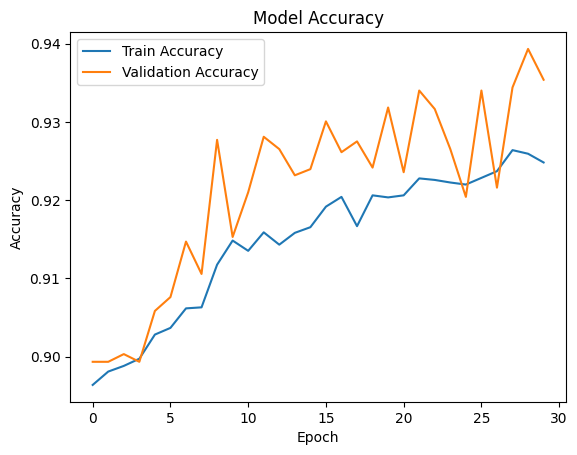

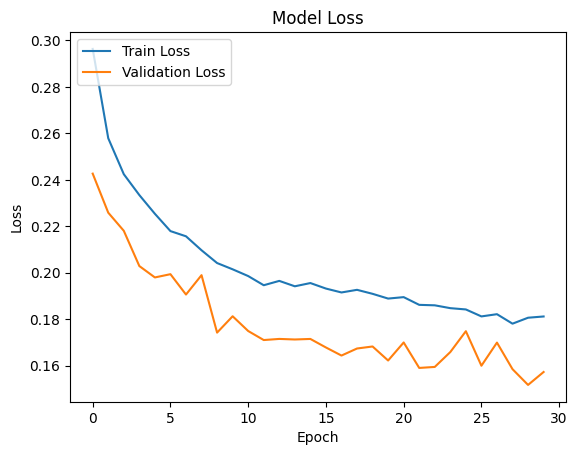

In [42]:
# Plot accuracy and loss history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [17]:
import pandas as pd

# Load features and labels from CSV
features_df = pd.read_csv('/content/drive/MyDrive/lstm_features.csv')
print("Shape of features:", features_df.shape)

# If labels are in a separate column or file
labels = features_df['label']  # Replace 'label' with the actual column name for labels
features_df = features_df.drop('label', axis=1)  # Remove label column from features

print("Shape of features after removing label column:", features_df.shape)


Shape of features: (25380, 15)
Shape of features after removing label column: (25380, 14)


In [73]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/lstm_model.h5')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [74]:
# Function to extract MFCC features from audio files
def extract_features(file_name, n_mfcc=13):
    audio, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_scaled = np.mean(mfccs.T, axis=0)  # Average over time steps
    return mfccs_scaled


In [75]:
import numpy as np

def preprocess_audio(file_path):
    # Extract the MFCC features (which results in a shape of (13,))
    mfccs_scaled = extract_features(file_path)

    # Ensure the shape is (1, 1, 13) to match the model's expected input shape
    mfccs_scaled = np.expand_dims(mfccs_scaled, axis=0)  # Shape becomes (1, 13)
    mfccs_scaled = np.expand_dims(mfccs_scaled, axis=1)  # Shape becomes (1, 1, 13)

    return mfccs_scaled


In [82]:

# Example usage for prediction
new_audio_features = preprocess_audio('/content/drive/MyDrive/flac/LA_T_1001871.flac')
prediction = model.predict(new_audio_features)

# Output the prediction result
if prediction > 0.5:
    print("Bonafide")
else:
    print("Spoof")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Spoof


In [83]:
from IPython.display import Audio
Audio('/content/drive/MyDrive/flac/LA_T_1001871.flac')